# Exemple de connexion a la base de donnée.

Pour l'use créez un fichier .env et dedans mettez :  
DB_HOST=  
DB_USER=  
DB_PASSWORD=  
DB_NAME=grape-mind  

In [ ]:
import os
from dotenv import load_dotenv
import mysql.connector

load_dotenv()

def get_connection():
    return mysql.connector.connect(
        host=os.getenv("DB_HOST"),
        user=os.getenv("DB_USER"),
        password=os.getenv("DB_PASSWORD"),
        database=os.getenv("DB_NAME")
    )

conn = get_connection()

cursor = conn.cursor()

# verif que bien connecté
cursor.execute("SELECT * FROM descriptifs LIMIT 5;")
rows = cursor.fetchall()
for row in rows:
    print(row)

#cursor.close()
#conn.close()

(101068, 'Sparkling', 'Assemblage/Blend', "['Chardonnay', 'Pinot Noir']", "['Pork', 'Rich Fish', 'Shellfish', 'Soft Cheese']", 12.0, 'Medium-bodied', 'High', 'FR', 'France', 1201, 'Champagne Premier Cru', 10412, 'Cave Geisse', 'http://www.cavegeisse.com.br', '[2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2002, 2000, 1998]', 'Philippe Dumont Champagne Brut Réserve Premier CruCave Geisse', None, None)
(103981, 'Rosé', 'Assemblage/Blend', "['Syrah/Shiraz', 'Grenache']", "['Pasta', 'Vegetarian', 'Appetizer', 'Snack', 'Lean Fish']", 12.5, 'Full-bodied', 'High', 'FR', 'France', 1398, "Pays d'Oc", 11889, 'Scanivinus', None, '[2020, 2019, 2018, 2014]', 'GW:s RosaScanivinus', None, None)
(105953, 'White', 'Assemblage/Blend', "['Chardonnay', 'Sauvignon Blanc']", "['Pork', 'Rich Fish', 'Shellfish', 'Vegetarian', 'Poultry']", 12.5, 'Full-bodied', 'High', 'FR', 'France', 1125, 'Alsace', 11877, 'Le Saumon', None, '[2018, 2017, 2016]', 'Organic Chardonnay-Sauvignon BlancLe 

# 🍇 Etude de l'impact du millésime sur la qualité du vin  
On se base ici sur la note donnée dans notre table `all_reviews`


Output de la regression lineaire :
Coeff : 0.0257787522632654
Intercept : 3.786799792116559
R^2 : 0.05037323825587914


/Users/maxime/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


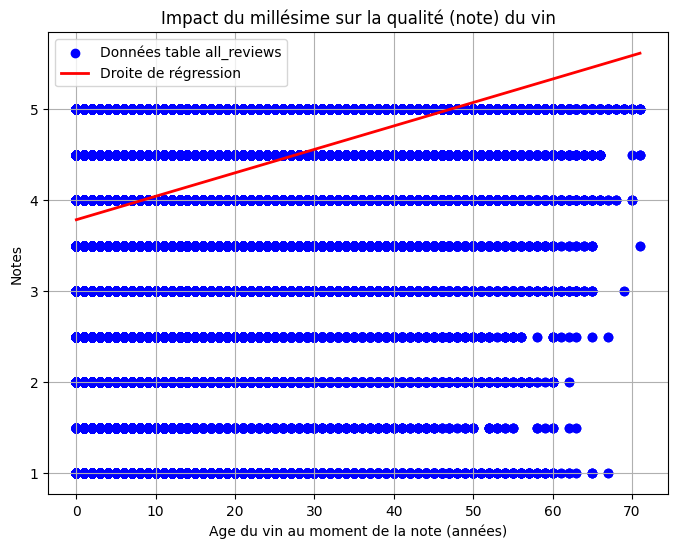

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

cursor.execute("SELECT * FROM all_reviews;")
data = cursor.fetchall()


df = pd.DataFrame(data, columns=cursor.column_names)


df['Date'] = pd.to_datetime(df['Date'])
df['ReviewYear'] = df['Date'].dt.year

# Conversion pour eviter les erreurs de merde de panda
df['Vintage'] = pd.to_numeric(df['Vintage'], errors='coerce')
df.dropna(subset=['Vintage'], inplace=True)
df['Vintage'] = df['Vintage'].astype(int)

# Calcul de l'age du vin au moment de la review (note)
df['WineAge'] = df['ReviewYear'] - df['Vintage']

X = df[['WineAge']]  # scikit-learn attends un X et Y
y = df['Rating']

# appel et ajustement du modèle sur nos données
model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

print("\nOutput de la regression lineaire :")
print("Coeff :", model.coef_[0])
print("Intercept :", model.intercept_)
print("R^2 :", r2_score(y, y_pred))


plt.figure(figsize=(8, 6))
plt.scatter(df['WineAge'], df['Rating'], color='blue', label='Données table all_reviews')
plt.plot(df['WineAge'], y_pred, color='red', linewidth=2, label='Droite de régression')
plt.xlabel("Age du vin au moment de la note (années)")
plt.ylabel("Notes")
plt.title("Impact du millésime sur la qualité (note) du vin")
plt.legend()
plt.grid(True)
plt.show()
